<a href="https://colab.research.google.com/github/zkc1031/BadmintonNetTouch/blob/main/main_workflow_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Googleドライブ連携
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#必要ライブラリのインストール


# 感嘆符(!)をつけると、ターミナルコマンドとして実行される
!pip install "numpy<2.0" mediapipe==0.10.9 ultralytics torch
# protobufとtensorflowは、Colabにプリインストールされている互換性のあるバージョンをそのまま使うのが安定します

In [ ]:
#フレームラベル付けシステム

# ライブラリのインポート
import os
import shutil
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image

# --- 設定 ---
# ラベル付け候補の画像が入っているフォルダ
SOURCE_DIR = '/content/drive/MyDrive/Badminton_Research/datasets/frames_to_label/'

# 分類後の画像を保存する親フォルダ
DEST_DIR_BASE = '/content/drive/MyDrive/Badminton_Research/datasets/labeled_data/'

# クラス名と、対応するフォルダ名
CLASSES = ['net_touch', 'over_net', 'normal']

# --- 関数の定義 ---

# 各クラスの保存先フォルダを作成する
for class_name in CLASSES:
    os.makedirs(os.path.join(DEST_DIR_BASE, class_name), exist_ok=True)
# スキップした画像用のフォルダも作成
os.makedirs(os.path.join(DEST_DIR_BASE, 'skipped'), exist_ok=True)

# SOURCE_DIRが存在するかチェック
if not os.path.exists(SOURCE_DIR):
    print(f"Error: Source directory not found at {SOURCE_DIR}")
    print("Please check if the path is correct and the directory exists in your Google Drive.")
else:
    # ファイルリストを取得し、シャッフルする
    image_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)

    # 現在のインデックスを管理する
    current_index = 0

    # 画像表示用のウィジェット
    image_widget = widgets.Image(format='png', width=800)

    # ボタンウィジェットの作成
    buttons = []
    for label in CLASSES + ['skip']:
        button = widgets.Button(description=label)
        buttons.append(button)

    # ボタンがクリックされたときの処理を定義
    def on_button_clicked(b):
        global current_index

        # 古い画像とボタンをクリア
        clear_output(wait=True)

        # 選択されたラベルに基づいてファイルを移動
        label = b.description
        if current_index < len(image_files):
            img_name = image_files[current_index]
            source_path = os.path.join(SOURCE_DIR, img_name)
            dest_path = os.path.join(DEST_DIR_BASE, label, img_name)

            try:
                shutil.move(source_path, dest_path)
                print(f"Moved '{img_name}' to '{label}' folder.")
            except Exception as e:
                print(f"Error moving file: {e}")

        # 次の画像へ
        current_index += 1
        show_next_image()

    # 各ボタンにクリックイベントを登録
    for button in buttons:
        button.on_click(on_button_clicked)

    # 次の画像を表示する関数
    def show_next_image():
        global current_index
        if current_index < len(image_files):
            img_name = image_files[current_index]
            img_path = os.path.join(SOURCE_DIR, img_name)

            # 画像を読み込んで表示
            with open(img_path, 'rb') as f:
                image_widget.value = f.read()

            # 進捗を表示
            progress_label = widgets.Label(f"Image {current_index + 1} / {len(image_files)}: {img_name}")

            # 画像とボタンをまとめて表示
            display(progress_label, image_widget, widgets.HBox(buttons))
        else:
            print("全ての画像の分類が完了しました！お疲れ様でした。")

    # 最初の画像を表示して開始
    if image_files:
        show_next_image()
    else:
        print("Source directory is empty or does not contain supported image files (.png, .jpg, .jpeg).")

Error: Source directory not found at /content/drive/MyDrive/Badminton_Research/datasets/frames_to_label/
Please check if the path is correct and the directory exists in your Google Drive.


In [ ]:
# 最初の画像を表示してラベリングを開始
show_next_image()

NameError: name 'show_next_image' is not defined

In [ ]:
#抽出用コード

# 必要なライブラリのインポート
import cv2
import mediapipe as mp
import os
import ntpath
from scipy.spatial import distance as dist
import numpy as np

# MediaPipeの新しいAPIのためのインポート
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# --- 設定 ---
# あなたがGoogle Driveにアップロードしたテスト用動画のパスに書き換えてください
VIDEO_PATH = '/content/drive/MyDrive/Badminton_Research/videos/test_video.mp4'

# 抽出した画像を保存するフォルダのパス
OUTPUT_DIR_FRAMES = '/content/drive/MyDrive/Badminton_Research/datasets/frames_to_label/'

# 物体検出モデルのパス
MODEL_PATH = '/content/drive/MyDrive/Badminton_Research/models/efficientdet_lite0.tflite'

# 判定の感度設定
DISTANCE_THRESHOLD = 150
DISPLAY_WIDTH = 1280 # Colabでは表示しないが、計算に使うため残す

# --- MediaPipeの準備 ---
mp_pose = mp.solutions.pose

# --- 補助関数 ---
def get_bbox_center(bbox):
    return (bbox.origin_x + bbox.width // 2, bbox.origin_y + bbox.height // 2)

# --- メイン処理 ---
def extract_important_frames():
    # フォルダの準備
    os.makedirs(OUTPUT_DIR_FRAMES, exist_ok=True)

    # ファイル存在チェック
    if not os.path.exists(VIDEO_PATH):
        print(f"エラー: 動画ファイルが見つかりません: {VIDEO_PATH}")
        return
    if not os.path.exists(MODEL_PATH):
        print(f"エラー: モデルファイルが見つかりません: {MODEL_PATH}")
        return

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print(f"エラー: 動画を開けませんでした: {VIDEO_PATH}")
        return

    # 最初のフレームでネットのROIを選択させる（ローカル実行時と同じUIが一時的に表示されます）
    ret, first_frame = cap.read()
    if not ret: return

    # この部分はColabでは直接表示されませんが、ROI選択のために必要です
    # 注意：Colabで実行すると、このUIは表示されず、デフォルト値(0,0,0,0)になる可能性があります。
    # その場合は、ROI座標を直接コードに書き込む必要があります。
    # 今回はまず、このまま実行してみましょう。
    cv2.putText(first_frame, "Select Net ROI, then press ENTER", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    net_roi = cv2.selectROI("Select Net ROI (in a temporary local window)", first_frame, fromCenter=False)
    cv2.destroyAllWindows()
    # selectROIがColabでうまく動かない場合、以下の行を有効にして手動で設定
    # net_roi = (x, y, w, h) # 例: net_roi = (600, 400, 700, 150)

    if net_roi == (0, 0, 0, 0):
        print("ROIが選択されませんでした。")
        return

    rx, ry, rw, rh = net_roi
    net_roi_center = (rx + rw // 2, ry + rh // 2)
    (h, w) = first_frame.shape[:2]

    video_filename = ntpath.basename(VIDEO_PATH).split('.')[0]
    frame_count = 0
    saved_count = 0

    # MediaPipeモデルの準備
    base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
    object_options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5, category_allowlist=["sports racket"])
    object_detector = vision.ObjectDetector.create_from_options(object_options)

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print("--- フレーム抽出を開始します ---")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break

            frame_count += 1
            if frame_count % 30 == 0: # 30フレームごとに進捗を表示
                print(f"Processing frame {frame_count} / {total_frames}...")

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            pose_results = pose.process(mp_image.numpy_view())
            detection_result = object_detector.detect(mp_image)

            if pose_results.pose_landmarks and detection_result.detections:
                racket_bbox = detection_result.detections[0].bounding_box
                racket_center = get_bbox_center(racket_bbox)

                landmarks = pose_results.pose_landmarks.landmark
                left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
                right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]

                left_wrist_pos = (int(left_wrist.x * w), int(left_wrist.y * h))
                right_wrist_pos = (int(right_wrist.x * w), int(right_wrist.y * h))

                dist_to_left = dist.euclidean(racket_center, left_wrist_pos)
                dist_to_right = dist.euclidean(racket_center, right_wrist_pos)

                racket_hand_pos = left_wrist_pos if dist_to_left < dist_to_right else right_wrist_pos

                d = dist.euclidean(racket_hand_pos, net_roi_center)

                if d < DISTANCE_THRESHOLD + (rw+rh)/2:
                    save_filename = f'{video_filename}_frame_{frame_count}.png'
                    save_path = os.path.join(OUTPUT_DIR_FRAMES, save_filename)
                    cv2.imwrite(save_path, frame)
                    saved_count += 1
                    print(f"  -> Frame {frame_count}: 接近を検知。画像を保存しました。({saved_count}枚目)")

    cap.release()
    print(f"--- 抽出完了 ---")
    print(f"合計 {saved_count} 枚の画像を '{OUTPUT_DIR_FRAMES}' に保存しました。")

--- センサーデータ詳細分析 (v2) ---

--- 読み込んだデータ（最初の5行） ---
                   time                DeviceName  AccX(g)  AccY(g)  AccZ(g)  \
0  2025-7-4 14:0:18.426  WT901BLE67(64A29F8949AD)    0.004   -0.005    1.001   
1  2025-7-4 14:0:18.514  WT901BLE67(64A29F8949AD)    0.003   -0.005    1.003   
2  2025-7-4 14:0:18.637  WT901BLE67(64A29F8949AD)    0.003   -0.004    1.001   
3  2025-7-4 14:0:18.725  WT901BLE67(64A29F8949AD)    0.003   -0.004    1.002   
4  2025-7-4 14:0:18.845  WT901BLE67(64A29F8949AD)    0.004   -0.005    1.003   

   AsX(°/s)  AsY(°/s)  AsZ(°/s)  AngleX(°)  AngleY(°)  ...  SpeedX(mm/s)  \
0       0.0    -0.122       0.0       0.19      -0.43  ...           NaN   
1       0.0    -0.122       0.0       0.19      -0.43  ...           NaN   
2       0.0    -0.061       0.0       0.19      -0.43  ...           NaN   
3       0.0    -0.122       0.0       0.19      -0.43  ...           NaN   
4       0.0    -0.122       0.0       0.19      -0.43  ...           NaN   

   SpeedY(mm

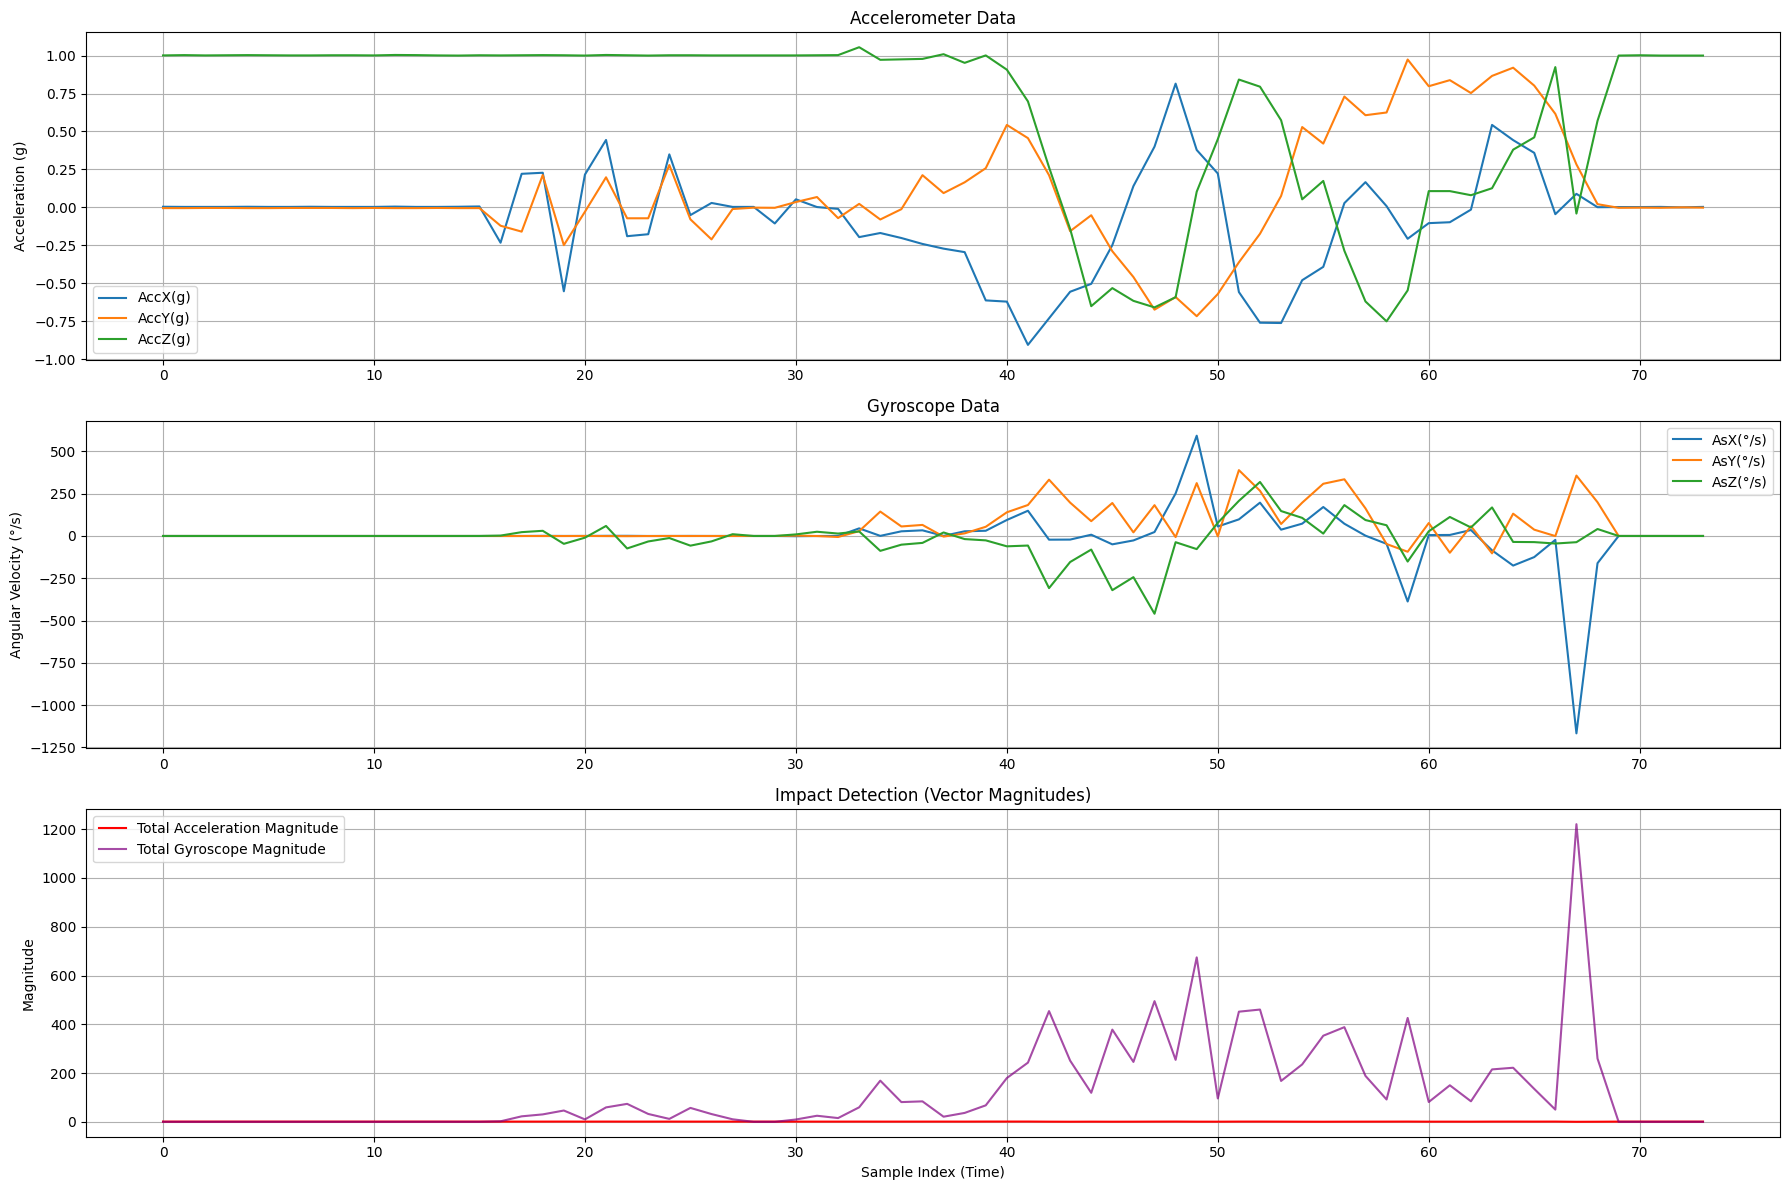

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

# --- 設定 ---
# あなたがアップロードしたセンサーデータのTXTファイルへのパス
SENSOR_DATA_PATH = '/content/drive/MyDrive/Badminton_Research/sensor_data/20250704140018.txt'

# --- メイン処理 ---
def analyze_sensor_data_v2(file_path):
    print(f"--- センサーデータ詳細分析 (v2) ---")
    if not os.path.exists(file_path):
        print(f"エラー: ファイルが見つかりません: {file_path}")
        return

    try:
        # WitMotionアプリのTXTファイルはタブ区切りなので、sep='\t'を指定
        # 最初の行がヘッダー（列名）であることを指定
        df = pd.read_csv(file_path, sep='\t', header=0)

        # --- データ最初の5行と列名を確認 ---
        print("\n--- 読み込んだデータ（最初の5行） ---")
        print(df.head())
        print("\n--- データの列名 ---")
        print(df.columns)

        # --- グラフ描画 ---
        # グラフを複数表示するための準備
        fig, axs = plt.subplots(3, 1, figsize=(18, 12)) # 縦に3つのグラフを並べる

        # 1. 加速度データのプロット
        acc_cols = ['AccX(g)', 'AccY(g)', 'AccZ(g)']
        for col in acc_cols:
            axs[0].plot(df.index, df[col], label=col)
        axs[0].set_title('Accelerometer Data')
        axs[0].set_ylabel('Acceleration (g)')
        axs[0].legend()
        axs[0].grid(True)

        # 2. 角速度データのプロット
        gyro_cols = ['AsX(°/s)', 'AsY(°/s)', 'AsZ(°/s)']
        for col in gyro_cols:
            axs[1].plot(df.index, df[col], label=col)
        axs[1].set_title('Gyroscope Data')
        axs[1].set_ylabel('Angular Velocity (°/s)')
        axs[1].legend()
        axs[1].grid(True)

        # 3.「合計の力」を計算してプロット（衝撃検知に最適）
        # 各軸の値を2乗して足し合わせ、平方根を取る
        df['TotalAcc'] = np.sqrt(df['AccX(g)']**2 + df['AccY(g)']**2 + df['AccZ(g)']**2)
        df['TotalGyro'] = np.sqrt(df['AsX(°/s)']**2 + df['AsY(°/s)']**2 + df['AsZ(°/s)']**2)

        axs[2].plot(df.index, df['TotalAcc'], label='Total Acceleration Magnitude', color='red')
        axs[2].plot(df.index, df['TotalGyro'], label='Total Gyroscope Magnitude', color='purple', alpha=0.7)
        axs[2].set_title('Impact Detection (Vector Magnitudes)')
        axs[2].set_xlabel('Sample Index (Time)')
        axs[2].set_ylabel('Magnitude')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nエラー: データの処理中に問題が発生しました。: {e}")

# --- 関数を実行 ---
analyze_sensor_data_v2(SENSOR_DATA_PATH)

--- 衝撃検出アルゴリズム実行 ---

--- 検出結果 ---
加速度のしきい値 (2.0 g) を超えた回数: 0 回
角速度のしきい値 (500 °/s) を超えた回数: 2 回
  -> 検出されたサンプル番号: [49, 67]


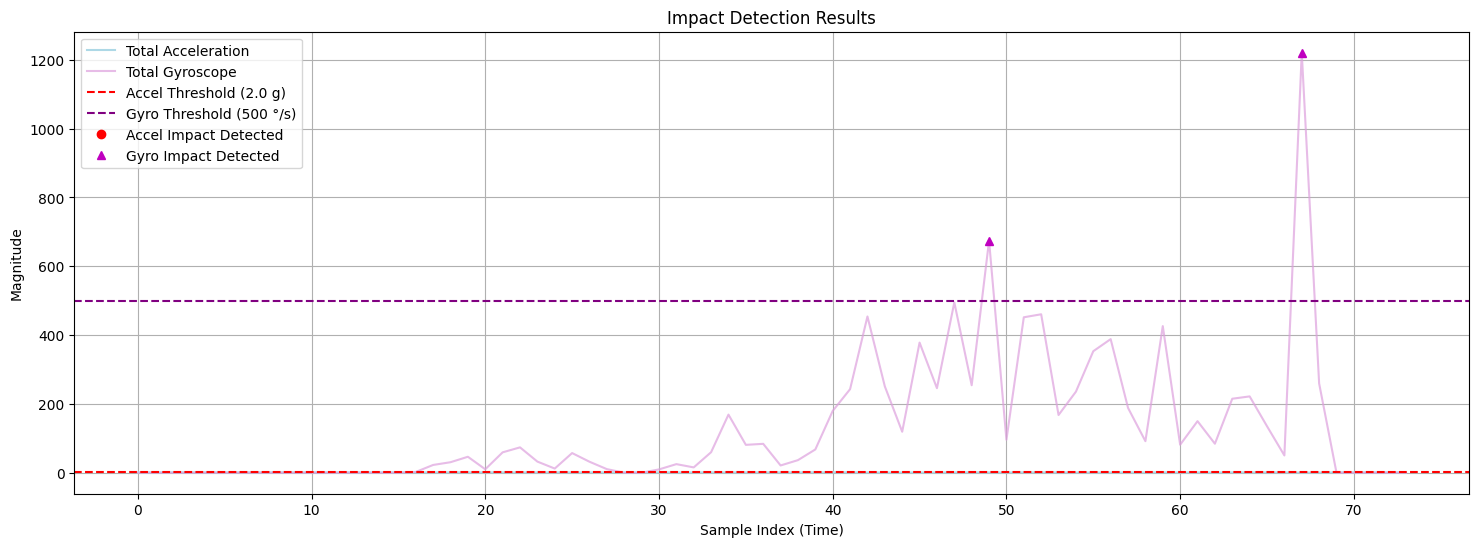

In [7]:
#衝撃検出テストコード
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

# --- 設定 ---
SENSOR_DATA_PATH = '/content/drive/MyDrive/Badminton_Research/sensor_data/20250704140018.txt'

# ★★★【重要】★★★
# この「しきい値」を調整して、衝撃を検出する感度を変えます
# まずはこのままで実行し、グラフを見てから調整しましょう
IMPACT_THRESHOLD_ACC = 2.0  # 合計加速度が 2.0g を超えたら衝撃と判断
IMPACT_THRESHOLD_GYRO = 500 # 合計角速度が 500°/s を超えたら衝撃と判断

# --- メイン処理 ---
def find_impacts(file_path):
    print(f"--- 衝撃検出アルゴリズム実行 ---")
    if not os.path.exists(file_path):
        print(f"エラー: ファイルが見つかりません: {file_path}"); return

    try:
        df = pd.read_csv(file_path, sep='\t', header=0)
        df.columns = df.columns.str.replace(r'\(.*\)', '', regex=True).str.strip()

        # 分析に使う列を数値型に変換
        for col in ['AccX', 'AccY', 'AccZ', 'AsX', 'AsY', 'AsZ']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # 「合計の力」を計算
        df['TotalAcc'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
        df['TotalGyro'] = np.sqrt(df['AsX']**2 + df['AsY']**2 + df['AsZ']**2)

        # しきい値を超えた場所（インデックス）を見つける
        acc_impacts = df[df['TotalAcc'] > IMPACT_THRESHOLD_ACC]
        gyro_impacts = df[df['TotalGyro'] > IMPACT_THRESHOLD_GYRO]

        print("\n--- 検出結果 ---")
        print(f"加速度のしきい値 ({IMPACT_THRESHOLD_ACC} g) を超えた回数: {len(acc_impacts)} 回")
        if not acc_impacts.empty:
            print("  -> 検出されたサンプル番号:", acc_impacts.index.tolist())

        print(f"角速度のしきい値 ({IMPACT_THRESHOLD_GYRO} °/s) を超えた回数: {len(gyro_impacts)} 回")
        if not gyro_impacts.empty:
            print("  -> 検出されたサンプル番号:", gyro_impacts.index.tolist())

        # --- 結果をグラフで可視化 ---
        plt.figure(figsize=(18, 6))

        # 背景のグラフ
        plt.plot(df.index, df['TotalAcc'], label='Total Acceleration', color='lightblue')
        plt.plot(df.index, df['TotalGyro'], label='Total Gyroscope', color='plum', alpha=0.7)

        # しきい値の線
        plt.axhline(y=IMPACT_THRESHOLD_ACC, color='red', linestyle='--', label=f'Accel Threshold ({IMPACT_THRESHOLD_ACC} g)')
        plt.axhline(y=IMPACT_THRESHOLD_GYRO, color='purple', linestyle='--', label=f'Gyro Threshold ({IMPACT_THRESHOLD_GYRO} °/s)')

        # 検出した衝撃の箇所にマーカーをプロット
        plt.plot(acc_impacts.index, acc_impacts['TotalAcc'], 'ro', label='Accel Impact Detected')
        plt.plot(gyro_impacts.index, gyro_impacts['TotalGyro'], 'm^', label='Gyro Impact Detected')

        plt.title('Impact Detection Results')
        plt.xlabel('Sample Index (Time)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"\nエラー: 処理中に問題が発生しました: {e}")

# --- 関数を実行 ---
find_impacts(SENSOR_DATA_PATH)

In [8]:
#カメラとセンサー同期コード

import numpy as np

# --- STEP 1: 将来、AIが出力するであろうデータの「ダミー」を用意 ---

# 【ダミー】映像AIからの出力結果
# (フレーム番号, イベントの種類) のリスト
video_events = [
    (1250, 'sync_action'),     # カチンコの瞬間
    (3800, 'potential_touch'), # タッチの可能性があるフレーム
    (9500, 'potential_touch')  # タッチの可能性があるフレーム
]

# 【ダミー】センサーAIからの出力結果
# (サンプル番号, 衝撃の強さ) のリスト
sensor_events = [
    (3500, 9.8), # カチンコの衝撃
    (6350, 4.5), # プレー中の何らかの強い衝撃
    (15000, 2.8) # プレー中の弱い衝撃
]

# --- STEP 2: 同期のための「設定」 ---

# 同期アクションが起きた基準点を設定
VIDEO_SYNC_FRAME = 1250
SENSOR_SYNC_INDEX = 3500

# 各データのサンプリングレート（1秒あたりのデータ数）を設定
# ※これは実際の機材に合わせて後で修正します
VIDEO_FPS = 240.0 # GoProが1秒あたり240フレーム
SENSOR_SPS = 100.0 # センサーが1秒あたり100サンプル (仮定)

# 判定の許容誤差（フレーム数）
# センサーの衝撃と映像の接触が、このフレーム数以内なら「一致」と見なす
TOLERANCE_FRAMES = 12 # 240fpsの場合、12フレーム = 0.05秒

# --- STEP 3: 同期と最終判定を行う関数 ---

def synchronize_and_judge(video_events, sensor_events):
    print("--- 同期と最終判定を開始します ---")

    final_judgements = []

    # センサーで検知したイベントを一つずつチェック
    for sensor_index, sensor_magnitude in sensor_events:
        # このイベントが「カチンコ」の衝撃そのものなら、スキップ
        if sensor_index == SENSOR_SYNC_INDEX:
            continue

        # 1. センサーイベントが、基準点から何サンプル後に起きたかを計算
        delta_samples = sensor_index - SENSOR_SYNC_INDEX

        # 2. サンプル数を秒数に変換
        delta_seconds = delta_samples / SENSOR_SPS

        # 3. 秒数を映像のフレーム数に変換
        delta_frames = delta_seconds * VIDEO_FPS

        # 4. 映像の基準点に、計算したフレーム数を足して、対応するフレーム番号を割り出す
        estimated_video_frame = VIDEO_SYNC_FRAME + delta_frames

        print(f"\nセンサーイベント (サンプル番号: {sensor_index}, 衝撃: {sensor_magnitude})")
        print(f" -> 映像の {int(estimated_video_frame)} フレーム目に相当すると推定。")

        # 5. 推定されたフレーム番号の近くで、映像AIも何かを検知しているか探す
        found_match = False
        for video_frame, event_type in video_events:
            if event_type == 'sync_action':
                continue

            # 映像イベントと推定フレームの差が、許容誤差内かチェック
            if abs(video_frame - estimated_video_frame) <= TOLERANCE_FRAMES:
                print(f"  -> ★★★ 一致を発見！ ★★★")
                print(f"     映像イベント (フレーム番号: {video_frame}) と近接しています。")

                # 最終判定結果をリストに追加
                final_judgements.append({
                    'sensor_index': sensor_index,
                    'video_frame': video_frame,
                    'judgement': 'Confirmed Net Touch',
                    'detail': f"Sensor impact ({sensor_magnitude}) matches video event."
                })
                found_match = True
                break # 一致が見つかったら、次のセンサーイベントのチェックへ

        if not found_match:
            print("  -> 映像側に対応するイベントが見つかりませんでした。")

    print("\n--- 最終判定結果 ---")
    if not final_judgements:
        print("確定したイベントはありませんでした。")
    else:
        for i, judgement in enumerate(final_judgements):
            print(f"【確定イベント {i+1}】")
            for key, value in judgement.items():
                print(f"  {key}: {value}")

    return final_judgements


# --- 実行 ---
final_results = synchronize_and_judge(video_events, sensor_events)

--- 同期と最終判定を開始します ---

センサーイベント (サンプル番号: 6350, 衝撃: 4.5)
 -> 映像の 8090 フレーム目に相当すると推定。
  -> 映像側に対応するイベントが見つかりませんでした。

センサーイベント (サンプル番号: 15000, 衝撃: 2.8)
 -> 映像の 28850 フレーム目に相当すると推定。
  -> 映像側に対応するイベントが見つかりませんでした。

--- 最終判定結果 ---
確定したイベントはありませんでした。
